# Sentiment Analysis of Yelp reviews: Word Embeddings and LSTM

In this notebook, we implement a sentiment analysis to associate stars (from 1 to 5) to the reviews of the [YelpReviewFull dataset](https://pytorch.org/text/stable/datasets.html#yelpreviewfull). 
This dataset consists of reviews from Yelp, and is extracted from the Yelp Dataset Challenge 2015 data. 
A data point of this dataset comprises a review's text and the corresponding label (1 to 5 stars).

For this, we will first use ..WORD EMBEDDINGS... TO...    [ResNet](https://arxiv.org/abs/1512.03385)

Then, we will use XXX... to...    [ResNet](https://arxiv.org/abs/1512.03385)

We achieve a XX% ...

To build this notebook, the hints given by the [Udacity](https://github.com/udacity/deep-learning-v2-pytorch/blob/master/sentiment-rnn/Sentiment_RNN_Solution.ipynb) team have been very useful.



We decide to group **4 and 5 stars** reviews as **"good"**, **3 stars** as **"neutral"**, and **1 and 2 stars** as **"bad"**.

In the following, we will try to **predict** if a review is good, neutral or bad.



To begin with, we install the libraries that are necessary to run the code on [Google Colab](https://colab.research.google.com/). 
<br/> ("capture" permits to hide the output cell)

In [2]:
%%capture  
%%bash
pip install torch==1.11.0
pip install folium==0.2.1
pip install torchdata
pip install datasets

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch
from torch import optim
import torchdata
import torch.nn as nn
import torch.nn.functional as F
from torchtext import transforms, utils, models #, datasets 

# Data pre-processing:

## Data loading and reduction:

We download the data with the [Hugging Face](https://huggingface.co/) library **datasets**. 

(The direct downloading from torchtext.datsets is impossible for now, because of a bug that will be corrected in the next version of PyTorch.)

In [4]:
from datasets import load_dataset
train_data = load_dataset("yelp_review_full", split="train")
test_data = load_dataset("yelp_review_full", split="test")

reviews = train_data['text'] + test_data['text']
stars = train_data['label'] + test_data['label']

Generating train split:   0%|          | 0/650000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset yelp_review_full downloaded and prepared to /root/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf. Subsequent calls will reuse this data.


Reusing dataset yelp_review_full (/root/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf)


We observe some data to see of all is OK.

In [5]:
print(f"A review example:   \"{reviews[2]}\"")
print()
print(f"The related label (number of stars):  {stars[2]} stars")

A review example:   "Been going to Dr. Goldberg for over 10 years. I think I was one of his 1st patients when he started at MHMG. He's been great over the years and is really all about the big picture. It is because of him, not my now former gyn Dr. Markoff, that I found out I have fibroids. He explores all options with you and is very patient and understanding. He doesn't judge and asks all the right questions. Very thorough and wants to be kept in the loop on every aspect of your medical health and your life."

The related label (number of stars):  3 stars


The full dataset contains a very big number of reviews: 700,000.

In [6]:
print(f"Number of reviews of the full dataset:  {len(reviews)}")

Number of reviews of the full dataset:  700000


Let us look at the full distribution of stars given to the reviews.

In [7]:
from collections import Counter

print(f"Number of reviews with 1 STAR of the INITIAL dataset:  {100*stars.count(0)/len(stars)} %")
print(f"Number of reviews with 2 STARS of the INITIAL dataset:  {100*stars.count(1)/len(stars)} %")
print(f"Number of reviews with 3 STARS of the INITIAL dataset:  {100*stars.count(2)/len(stars)} %")
print(f"Number of reviews with 4 STARS of the INITIAL dataset:  {100*stars.count(3)/len(stars)} %")
print(f"Number of reviews with 5 STARS of the INITIAL dataset:  {100*stars.count(4)/len(stars)} %")


Number of reviews with 1 STAR of the INITIAL dataset:  20.0 %
Number of reviews with 2 STARS of the INITIAL dataset:  20.0 %
Number of reviews with 3 STARS of the INITIAL dataset:  20.0 %
Number of reviews with 4 STARS of the INITIAL dataset:  20.0 %
Number of reviews with 5 STARS of the INITIAL dataset:  20.0 %


We decide to keep only **20%** of the original YelpReviewsFull dataset for our analysis (140,000 reviews!).
We carry out the selection **by preserving the equal distribution of stars**.

In [8]:
# We choose the indices that will be used
indices_1_Star = [index for index in range(len(reviews)) if stars[index]==0]
indices_2_Star = [index for index in range(len(reviews)) if stars[index]==1]
indices_3_Star = [index for index in range(len(reviews)) if stars[index]==2]
indices_4_Star = [index for index in range(len(reviews)) if stars[index]==3]
indices_5_Star = [index for index in range(len(reviews)) if stars[index]==4]

# We shuffle these indexes and delect randomly 20% of them
np.random.seed(123)
np.random.shuffle(indices_1_Star)
np.random.shuffle(indices_2_Star)
np.random.shuffle(indices_3_Star)
np.random.shuffle(indices_4_Star)
np.random.shuffle(indices_5_Star)
selected_indices_1_Star = indices_1_Star[:len(indices_1_Star)//5]
selected_indices_2_Star = indices_2_Star[:len(indices_2_Star)//5]
selected_indices_3_Star = indices_3_Star[:len(indices_3_Star)//5]
selected_indices_4_Star = indices_4_Star[:len(indices_4_Star)//5]
selected_indices_5_Star = indices_5_Star[:len(indices_5_Star)//5]

selected_indices = selected_indices_1_Star + selected_indices_2_Star + selected_indices_3_Star + selected_indices_4_Star + selected_indices_5_Star
reviews = [reviews[index] for index in selected_indices]
stars = [stars[index] for index in selected_indices]

print(f"Number of reviews kept for our analysis:  {len(reviews)}")

Number of reviews kept for our analysis:  140000


We check that the distribution of different stars is still the same.

In [9]:
print(f"Number of reviews with 1 STAR of the SELECTED dataset:  {100*stars.count(0)/len(stars)} %")
print(f"Number of reviews with 2 STARS of the SELECTED dataset:  {100*stars.count(1)/len(stars)} %")
print(f"Number of reviews with 3 STARS of the SELECTED dataset:  {100*stars.count(2)/len(stars)} %")
print(f"Number of reviews with 4 STARS of the SELECTED dataset:  {100*stars.count(3)/len(stars)} %")
print(f"Number of reviews with 5 STARS of the SELECTED dataset:  {100*stars.count(4)/len(stars)} %")

Number of reviews with 1 STAR of the SELECTED dataset:  20.0 %
Number of reviews with 2 STARS of the SELECTED dataset:  20.0 %
Number of reviews with 3 STARS of the SELECTED dataset:  20.0 %
Number of reviews with 4 STARS of the SELECTED dataset:  20.0 %
Number of reviews with 5 STARS of the SELECTED dataset:  20.0 %


## Data tokenization:

We now **tokenize** the reviews in order to make them readable by our neuronal network. For this we carry out the following steps:

- First, we **remove punctuation** and transform **upper cases into lower cases**.

- Second, we **tokenize** the words, by assigning to each of them an **integer**.

- Finally, we **translate** the reviews into tokenized reviews (by replacing each word by its corresponding integer).

Let us begin with punctuation and upper cases.

In [10]:
from string import punctuation

# Remove punctuation and upper cases
all_reviews = ' new_review_xyz '.join([review.translate(str.maketrans('', '', punctuation)) for review in reviews]) 
all_reviews = all_reviews.lower()

# Split again the different reviews
reviews_split = all_reviews.split(' new_review_xyz ')
all_reviews = ' '.join(reviews_split)

# Create a list containing all the words
all_words = all_reviews.split()

# We delete useless variables to increase available RAM
del all_reviews

# Check if all is OK with one review
print(reviews_split[0])

food is good  service at the bar is excellent   franco dropping f bombs at the the bar is a total turn off  tell him to stay in the kitchennnwe came back 6 months later  and had the most bizarre experience  the owner chef came out of the kitchen and verbally attacked a table of patronsnhe said that he was not happy with their disappointment with one of their dinners  he challenged them to the parking lot where he was going to punch the fbomb out of them the customers told him to stand back and even asked if the police could be called  the food is still good yet over pricedngo only at your own risk


Now, let us **encode the words into integers**: we do this by building a **dictionary** that maps all the present words into integers. It will permit us to **convert the reviews into a list of integers**. We **keep the value 0 for the padding**, that will be carried out next to have reviews of same size.

In [11]:
# Count occurences of each word
words_occurences = Counter(all_words) 
# Sort the words from the most to the least present
words_sorted = sorted(words_occurences, key=words_occurences.get, reverse=True) 
# Build the dictionary that maps words to integers: we keep "0" for the padding
word_to_integer = {word: integer for integer, word in enumerate(words_sorted, start=1)} 


## Tokenize each review in reviews_split and store the tokenized reviews in reviews_tokenized
reviews_tokenized = []
for review in reviews_split:
    reviews_tokenized.append([word_to_integer[word] for word in review.split()])
    

In [12]:
# Number of unique words
print('Number of unique words: ', len((word_to_integer))) 
print()

print('Example of tokenized review: \n', reviews_tokenized[1])
print()

print('The same review before tokenization: \n', reviews_split[1])


# We delete useless variables to increase available RAM
del all_words
del reviews_split
del words_occurences
del words_sorted

Number of unique words:  279087

Example of tokenized review: 
 [4, 6, 10, 482, 133, 5, 3545, 58405, 3330, 296, 2, 4644, 206, 6, 44, 7, 1, 206, 3875, 75, 1, 296, 4, 76, 3, 120, 25, 32535, 10600, 3331, 312, 63, 23, 3, 52, 618, 14, 120, 9070, 134, 35816, 33, 19, 74, 144, 20, 1412, 6, 669, 16, 856, 1486, 1782, 6, 10, 537, 7, 625, 375, 7, 4548, 4420, 374, 44, 429, 3742, 16, 146, 1082, 24, 605, 32, 9, 1279, 388, 1840, 553, 255, 2, 62, 85374, 100, 59, 56, 32]

The same review before tokenization: 
 i was in las vegas to attend asd trade show and ti hotel was one of the hotel referred by the show  i got a room at 33rd flood facing strip  which had a great view but room smelt bad furnitures as you can see on picture was dirty with dark spots nobody was in charge of taking care of hallways leftover dishes  one ice bucket with few glasses were stayed there for 24 hours  towels looks old and some dirtynnever never go back there


## Preparation of the features matrix (containing tokenized customized reviews)

We prepare the review matrix, by **standardizing** the lenght of the reviews to **300** words, to make the neuronal network comutations reasonable:

- We **remove** the reviews with no text.   XXXX

- We  **add zeros** to the reviews that are **too short**.   XXXX

- We **truncate** reviews that are **too long**.   XXXX


Let us first **check** whether there are **reviews with no text**.

In [13]:
# Size of the reviews
reviews_lenghts = [len(x) for x in reviews_tokenized]

print("Number of reviews with no words: {}".format(min(reviews_lenghts)))


Number of reviews with no words: 0


There are **no reviews with no words**.

Now, let us check the **maximal, median, and average number of words in a review**.

In [14]:
print("Maximal number of words in a review: {}".format(max(reviews_lenghts)))
print("Median number of words in a review: {}".format(np.median(reviews_lenghts)))
print("Average number of words in a review: {}".format(np.mean(reviews_lenghts)))
print("Average number of words in a review + 2 standard deviations: {}".format(np.mean(reviews_lenghts) + 2*np.std(reviews_lenghts)))

Maximal number of words in a review: 1025
Median number of words in a review: 99.0
Average number of words in a review: 133.38750714285715
Average number of words in a review + 2 standard deviations: 374.6552661842528


Based on these statistics, we decide to customize the length of our reviews at **300 words**.

Thus, let us **trunctate** reviews that are too long, and **add zeros** to reviews that are too short, to create the **matrix of features** that will be used as **predictor** in our neuronal network.

In [15]:
# Create the matrix of features, that will be entered in the neuronal network
# Its size must be of (number_of_reviews * maximum_number_of_words_per_review)
max_words_per_review = 300
matrix_features = np.zeros((len(reviews_tokenized), max_words_per_review), dtype=int)

# We put the tokenized words in the matrix, for each review (and truncate at the maximum review length)
for review_number, words_in_review in enumerate(reviews_tokenized):
    matrix_features[review_number, :len(words_in_review)] = np.array(words_in_review)[:max_words_per_review]
    
# We look at the last columns of the matrix of features (tokenized and standardized reviews), to check if all is OK
print(matrix_features[:, :])
    

[[  28   11   30 ...    0    0    0]
 [   4    6   10 ...    0    0    0]
 [  17   31  633 ...   55   79   72]
 ...
 [ 109  259    7 ...    0    0    0]
 [ 766 2386 3189 ...    0    0    0]
 [   4  260    5 ...    1  394 3105]]


## Transforming stars into "good", "neutral", and "bad" reviews

We decide to group **4 and 5 stars** reviews as **"good"**, **3 stars** as **"neutral"**, and **1 and 2 stars** as **"bad"**.

In the following, we will try to **predict** if a review is good, neutral or bad.

In [17]:
# 5 or 4 stars => "good"
good = [1 if (star == 4 or star ==3) else 0 for star in stars]
# 3 stars => "neutral"
neutral = [1 if (star == 2) else 0 for star in stars]
# 2 or 1 star => "bad"
bad = [1 if (star == 1 or star ==0) else 0 for star in stars]

# 3 variables put together in a matrix
goodness = np.array([good, neutral, bad], dtype=int)
goodness = goodness.T

## Preparation of the training, test, and validation datasets

We now divide our prepared data into the **training set** (**80% of the data**), the **test set** (**10% of the data**), and the **validation set** (**10% of the data**).

In [18]:
train_prop = 0.8
valid_prop = 0.1
test_prop = 1 - (train_prop+valid_prop)

train_len = int(len(reviews_tokenized)*train_prop)
valid_len = int(len(reviews_tokenized)*valid_prop)

train_reviews, valid_reviews, test_reviews = matrix_features[:train_len], matrix_features[train_len:train_len+valid_len], matrix_features[train_len+valid_len:]
train_goodness, valid_goodness, test_goodness = goodness[:train_len], goodness[train_len:train_len+valid_len], goodness[train_len+valid_len:]

## We check the number of reviews in each dataset
print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_reviews.shape), 
      "\nValidation set: \t{}".format(valid_reviews.shape),
      "\nTest set: \t\t{}".format(test_reviews.shape))

			Feature Shapes:
Train set: 		(112000, 300) 
Validation set: 	(14000, 300) 
Test set: 		(14000, 300)


## Format the data for PyTorch

We prepare the data to make it readable for our PyTorch Neuronal Network.

In [19]:
from torch.utils.data import TensorDataset, DataLoader

# Build Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_reviews), torch.from_numpy(train_goodness))
valid_data = TensorDataset(torch.from_numpy(valid_reviews), torch.from_numpy(valid_goodness))
test_data = TensorDataset(torch.from_numpy(test_reviews), torch.from_numpy(test_goodness))

# Define batch size
batch_size = 50

# Build the batches: we use drop_last to avoid size issues with last batch
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last=True)


# Check one batch of the training set to see if all OK
train_iter = iter(train_loader)
example_reviews, example_goodness = train_iter.next()

print('Reviews batch size (number of reviews in batch, words per review): ', example_reviews.size()) 
print('Example reviews batch: \n', example_reviews)
print()
print('Goodness batch size (number of goodness labels per batch): ', example_goodness.size()) 
print('Example goodness batch: \n', example_goodness)

Reviews batch size (number of reviews in batch, words per review):  torch.Size([50, 300])
Example reviews batch: 
 tensor([[    28,     33,    124,  ...,      0,      0,      0],
        [   482,    133,     11,  ...,      0,      0,      0],
        [     1, 208037,    217,  ...,      0,      0,      0],
        ...,
        [    18,     27,    314,  ...,      0,      0,      0],
        [114612,    121,     93,  ...,      0,      0,      0],
        [    13,    280,      2,  ...,      0,      0,      0]])

Goodness batch size (number of goodness labels per batch):  torch.Size([50, 3])
Example goodness batch: 
 tensor([[0, 0, 1],
        [0, 0, 1],
        [1, 0, 0],
        [1, 0, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [0, 0, 1],
        [0, 1, 0],
        [0, 0, 1],
        [1, 0, 0],
        [0, 0, 1],
        [0, 1, 0],


# Building the Neuronal Network: Embedding and LSTM

We now build the neuronal network *per se*. Our network is **composed of 2 layers**:

- First, an **Embedding layer** that permits to have a less heavy representation of the reviews than the **hundreds of thousands of one-hot encoded words**: it is useful to **improve** the training **efficiency**. We use for this the [PyTorch Embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) function.

- Second, an **LSTM layer** (Long Short-Term Memory). [LSTM](https://pubmed.ncbi.nlm.nih.gov/9377276/) permits to avoid the issue of **vanishing gradients** that occurs with basic RNNs. We use here the [PyTorch LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html?highlight=lstm#torch.nn.LSTM) function.



**Note for the LSTM:** There are two different ways to **initialize the hidden and cell state** when switching from one batch to another: in the **stateful mode**, the final states of the previous batch are set as the initial state in the next batch, while in **stateless mode**, the next batch states are initialized with zeros.
<br/> $\rightarrow$ **We want our RNN to be stateless**, so it can build its hidden and cell states independently in each batch.




In [20]:
# To check whether GPU is available
train_on_gpu=torch.cuda.is_available()

class SentimentAnalysisRNN(nn.Module):
    """ 
    Recurrent Neuronal Networrk composed of an Embedding layer and an LSTM layer.
    Args:
        vocabulary_size (_int_): Number of features in the input of the Embedding layer: it is total number of words in the vocabulary + 1 (the "+1" is for the "zeros").
        output_size (_int_): Desired size of the final output of the SentimentAnalysisRNN.
        embedding_dim (_int_): Size of each embedding vector.
        lstm_hidden_size (_int_): Number of features in the hidden state of the LSTM.
        lstm_n_layers (_int_): Number of layers in the LSTM.
        dropout (_float_): The dropout probability used in the LSTM to reduce overfitting. (introduces a Dropout layer on the outputs of each LSTM layer except the last layer)
        dropout_last_layer (_float_): The dropout probability used in the LSTM last layer.
    """
    
    def __init__(self, vocabulary_size, output_size, embedding_dim, lstm_hidden_size, lstm_n_layers, dropout=0.5, dropout_last_layer=0.5):
        """
        Initialization.
        """
        super(SentimentAnalysisRNN, self).__init__()
        self.output_size = output_size
        self.lstm_hidden_size = lstm_hidden_size
        self.lstm_n_layers = lstm_n_layers
        # Embedding layer
        self.embedding = nn.Embedding(num_embeddings = vocabulary_size, 
                                      embedding_dim = embedding_dim)
        # LSTM layer
        self.lstm = nn.LSTM(input_size = embedding_dim, 
                            hidden_size = lstm_hidden_size, 
                            num_layers = lstm_n_layers, 
                            dropout = dropout, 
                            batch_first=True)    # So input and output tensors are provided as (batch, seq, feature) instead of (seq, batch, feature).
        # Dropout for LSTM last layer
        self.dropout_last_layer = nn.Dropout(p = dropout_last_layer)
        # Linear and Softmax layers
        self.fc = nn.Linear(lstm_hidden_size, output_size)
        self.softmax = nn.Softmax()
        
        
    def forward(self, x, hidden_and_cell):
        """ 
        Forward step
        Args:
            x (_tensor_): batch of inputs used in the forward step
            hidden_and_cell (_tensor_): hidden and cell states used in the forward step (see init_hidden_statefull() for more details)
        """
        batch_size = x.size(0)
        # Embedding and LSTM layers
        x = x.long() 
        embedded_x = self.embedding(x)
        lstm_output, hidden = self.lstm(embedded_x, hidden_and_cell)
        lstm_output = lstm_output[:, -1, :] # To take the last time step output
        lstm_output = self.dropout_last_layer(lstm_output)
        # Linear and Softmax layers
        linear_output = self.fc(lstm_output)
        # sigmoid function
        output = self.softmax(linear_output)
        # return last sigmoid output and hidden state
        return output, hidden_and_cell
    
    
    def init_hidden_cell_stateless(self, batch_size):
        """
        Initialization of the hidden and cell states: the hidden and cell states are initialized at 0 for 
        each batch ("stateless mode").
        (Not like in the "stateful mode", where the hidden state is memorized from one batch to another.)

        Args:
            batch_size (_int_): size of a batch
        """
        # The zeros tensors for the hidden state and cell state of LSTM must be 
        # of dimension lstm_n_layers x batch_size x hidden_dim.
        
        # To get this dimension, we first get an item of the parameters 
        # (the hidden state parameters) of the model "self" (the LSTM model).
        weight = next(self.parameters()).data
        
        # Then, we create a zeros tensor that has the same dimension as this item (thus,
        # the same dimension as the hidden and cell states).
        if (train_on_gpu):
            hidden_and_cell = (weight.new(self.lstm_n_layers, batch_size, self.lstm_hidden_size).zero_().cuda(),
                               weight.new(self.lstm_n_layers, batch_size, self.lstm_hidden_size).zero_().cuda())
        else:
            hidden_and_cell = (weight.new(self.lstm_n_layers, batch_size, self.lstm_hidden_size).zero_(),
                               weight.new(self.lstm_n_layers, batch_size, self.lstm_hidden_size).zero_())
        return hidden_and_cell

We set the **hyperparameters** and create the model.

In [21]:
# Instantiate the model w/ hyperparams
vocabulary_size = len(word_to_integer) + 1 # "+1" for the zeros, as mentioned earlier
output_size = 3
embedding_dim = 400
lstm_hidden_size = 256
lstm_n_layers = 2

sentimentNet = SentimentAnalysisRNN(vocabulary_size, output_size, embedding_dim, lstm_hidden_size, lstm_n_layers)

print(sentimentNet)

SentimentAnalysisRNN(
  (embedding): Embedding(279088, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout_last_layer): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=3, bias=True)
  (softmax): Softmax(dim=None)
)


# Training the model

We now train our Neuronal Network, with the training and validation datasets.

Let us first set some parameters for the **optimization**.

In [22]:
# Learning rate
lr=0.001

# Loss criterion : we use the Negative Log-Likelihood Loss function (NLL) as we have a softmax function as an output activation layer. 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(sentimentNet.parameters(), lr=lr)

# We use GPU if it's available, and the CPU otherwise
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sentimentNet.to(device);

We use **gradient clipping** (error derivative is changed to a threshold during backward propagation, and thenused to update the weights) to decrease the likelihood of exploding or vanishing gradients.

In [23]:
# gradient clipping
clip=5

And now, we carry out the **training** and **validation** steps.

Let us note that the **validation accuracy is higher than the training accuracy**: this is **due to the dropout used in the training**. 
Indeed, when training, a percentage of the features are set to zero (*100p*% whith a Dropout(*p*)).
When testing, all features are used, so the model at test time can lead to higher testing accuracies.


In [24]:
# Number of epochs used to train the model
n_epochs = 4

# Variables to keep track of the change in validation loss, to save the best model
valid_loss_min = np.Inf 
best_accuracy = 0.0

# Variables to keep the accuracies calculated at each epoch in order to plot them later
epoch_all = []  
valid_epoch_acc_all = []
train_epoch_acc_all = []

for epoch in range(1, n_epochs+1):
    
    # Initialize hidden and cell states
    hidden_and_cell = sentimentNet.init_hidden_cell_stateless(batch_size)

    # To keep track of training and validation loss and accuracy
    train_loss = 0.0
    valid_loss = 0.0
    valid_running_corrects = 0
    train_running_corrects = 0
    
    ###################
    # Train the model #
    ###################
    sentimentNet.train()
    for reviews, goodness in train_loader:
        # Move tensors to GPU if CUDA is available
        reviews, goodness = reviews.to(device), goodness.to(device)
        # Create new variables for the hidden and cell states, otherwise
        # would backpropagate through the entire training history
        hidden_and_cell = tuple([variable.data for variable in hidden_and_cell])
        # Clear the gradients of all optimized variables
        optimizer.zero_grad()
        # Forward pass: compute predicted outputs by passing images to the model
        output, hidden_and_cell = sentimentNet.forward(reviews, hidden_and_cell)
        # Calculate the batch loss
        loss = criterion(output.squeeze(), goodness.squeeze().float())
        # Backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # clip_grad_norm helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(sentimentNet.parameters(), clip)
        # Perform a single optimization step (parameter update)
        optimizer.step()
        # Update training loss
        train_loss += loss.item()*reviews.size(0)
        # To calculate the training set accuracy later: 
        # take as prediction the label with highest output (highest probability)
        pred = F.one_hot(output.argmax(1), num_classes=3)
        # Total number of correct predictions (we divide by 3 as there are 3 dimensions)
        train_running_corrects += torch.sum((pred==goodness).all(dim=1))
        
    ######################    
    # Validate the model #
    ######################
    
    # Initialize hidden and cell states for validation steps
    hidden_and_cell = sentimentNet.init_hidden_cell_stateless(batch_size)
    
    # We eval() our model to deactivate the dropout layers and directly pass all activations
    sentimentNet.eval()
    for reviews, goodness in valid_loader:
        # Move tensors to GPU if CUDA is available
        reviews, goodness = reviews.to(device), goodness.to(device)
        # Create new variables for the hidden and cell states, otherwise
        # would backpropagate through the entire training history
        hidden_and_cell = tuple([variable.data for variable in hidden_and_cell])
        # Forward pass: compute predicted outputs by passing images to the model
        output, hidden_and_cell = sentimentNet.forward(reviews, hidden_and_cell)
        # Calculate the batch loss
        loss = criterion(output.squeeze(), goodness.squeeze().float())
        # Update average validation loss 
        valid_loss += loss.item()*reviews.size(0)
        # To calculate the validation accuracy later: 
        # take as prediction the label with highest output (highest probability)
        pred = F.one_hot(output.argmax(1), num_classes=3)
        # Total number of correct predictions
        valid_running_corrects += torch.sum((pred==goodness).all(dim=1))
    
    # Calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    
    # Calculate accuracy
    train_epoch_acc = train_running_corrects.double() / len(train_loader.sampler)
    valid_epoch_acc = valid_running_corrects.double() / len(valid_loader.sampler)
        
    # Print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tTraining Accuracy: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.6f}'.format(
        epoch, train_loss, train_epoch_acc, valid_loss,valid_epoch_acc))
    
    # Save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(sentimentNet.state_dict(), 'sentimentNet_yelp.pt')
        valid_loss_min = valid_loss

    # We keep the accuracies at each epoch, to plot them later, and transfer them to the cpu
    # in order to convert the values into a numpy array and plot them
    epoch_all.append(epoch)    
    valid_epoch_acc_all.append(valid_epoch_acc.cpu())
    train_epoch_acc_all.append(train_epoch_acc.cpu())
    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1 	Training Loss: 0.958110 	Training Accuracy: 0.576937 	Validation Loss: 0.757022 	Validation Accuracy: 0.835643
Validation loss decreased (inf --> 0.757022).  Saving model ...
Epoch: 2 	Training Loss: 0.864230 	Training Accuracy: 0.672643 	Validation Loss: 0.868435 	Validation Accuracy: 0.654286
Epoch: 3 	Training Loss: 0.825464 	Training Accuracy: 0.715759 	Validation Loss: 0.773693 	Validation Accuracy: 0.761000
Epoch: 4 	Training Loss: 0.800682 	Training Accuracy: 0.744277 	Validation Loss: 0.734814 	Validation Accuracy: 0.805000
Validation loss decreased (0.757022 --> 0.734814).  Saving model ...


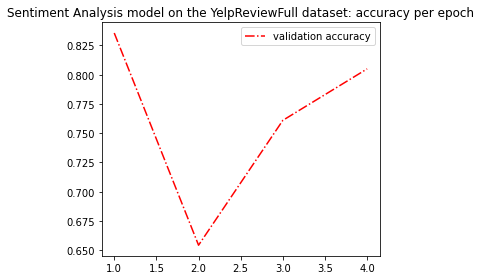

In [25]:
plt.plot(epoch_all, valid_epoch_acc_all, label="validation accuracy", color="red", linestyle='-.')
#plt.plot(epoch_all, train_epoch_acc_all, label="training accuracy", color="blue",linestyle='-.')
plt.title("Sentiment Analysis model on the YelpReviewFull dataset: accuracy per epoch")
plt.legend()
plt.tight_layout()
plt.show()

# First test of the model

We now **test** our model with the test dataset, that has not been used during the model training.

In [26]:
# We test our best model (the one with the lowest validation loss)
sentimentNet.load_state_dict(torch.load('sentimentNet_yelp.pt'))


# To keep track of test loss and accuracy
test_loss = 0.0
test_running_corrects = 0

# Initialize hidden and cell states for the test step
hidden_and_cell = sentimentNet.init_hidden_cell_stateless(batch_size)

# We eval() our model to deactivate the dropout layers and directly pass all activations
sentimentNet.eval()
for reviews, goodness in test_loader:
    # Move tensors to GPU if CUDA is available
    reviews, goodness = reviews.to(device), goodness.to(device)
    # Create new variables for the hidden and cell states, otherwise
    # would backpropagate through the entire training history
    hidden_and_cell = tuple([variable.data for variable in hidden_and_cell])
    # Forward pass: compute predicted outputs by passing images to the model
    output, hidden_and_cell = sentimentNet.forward(reviews, hidden_and_cell)
    # Calculate the batch loss
    loss = criterion(output.squeeze(), goodness.squeeze().float())
    # Update average validation loss 
    test_loss += loss.item()*reviews.size(0)
    # To calculate the validation accuracy later: 
    # take as prediction the label with highest output (highest probability)
    pred = F.one_hot(output.argmax(1), num_classes=3)
    # Total number of correct predictions
    test_running_corrects += torch.sum((pred==goodness).all(dim=1))

# calculate average loss
test_loss = test_loss/len(test_loader.sampler)
    
# claculate accuracy
test_epoch_acc = test_running_corrects.double() / len(test_loader.sampler)
        
# print training/validation statistics 
print('\tTest Loss: {:.6f} \tTest Accuracy: {:.6f}'.format(
    test_loss,test_epoch_acc))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


	Test Loss: 0.733083 	Test Accuracy: 0.806000


We finally get a **83%** test accuracy with our model !

# Second test of the model

We now **test** our model **on two personal comments** (one **positive** and one **negative**) that we write on our own.

In [77]:
# positive personal review
personal_review_positive = "This coding experiment was very nice: I enjoyed a lot all the steps. You can do so many things with mathematics. This motivates me a lot for future projects."

# negative personal review
personal_review_negative = "I did not enjoy at all the weather today. It was rainy and very cold, while I like when it's sunny and hot. It really ruined my visit. In addition, the museums were closed. So I had basically nothing to do."


We tokenize our two personal reviews.

In [78]:
reviews = [personal_review_positive, personal_review_negative]

# Remove punctuation and upper cases
all_reviews = ' new_review_xyz '.join([review.translate(str.maketrans('', '', punctuation)) for review in reviews]) 
all_reviews = all_reviews.lower()

# Split again the different reviews
reviews_split = all_reviews.split(' new_review_xyz ')
all_reviews = ' '.join(reviews_split)

# Create a list containing all the words
all_words = all_reviews.split()

# We delete useless variables to increase available RAM
del all_reviews

# Check if all is OK with one review
print(reviews_split[0])


this coding experiment was very nice i enjoyed a lot all the steps you can do so many things with mathematics this motivates me a lot for future projects


In [79]:
# Count occurences of each word
words_occurences = Counter(all_words) 
# Sort the words from the most to the least present
words_sorted = sorted(words_occurences, key=words_occurences.get, reverse=True) 
# Build the dictionary that maps words to integers: we keep "0" for the padding
word_to_integer = {word: integer for integer, word in enumerate(words_sorted, start=1)} 


## Tokenize each review in reviews_split and store the tokenized reviews in reviews_tokenized
reviews_tokenized = []
for review in reviews_split:
    reviews_tokenized.append([word_to_integer[word] for word in review.split()])
    

We create the matrix of features: it has two rows given that we have only two personal reviews.

In [80]:
# Create the matrix of features, that will be entered in the neuronal network
# Its size must be of (number_of_reviews * maximum_number_of_words_per_review)
max_words_per_review = 300
matrix_features = np.zeros((len(reviews_tokenized), max_words_per_review), dtype=int)

# We put the tokenized words in the matrix, for each review (and truncate at the maximum review length)
for review_number, words_in_review in enumerate(reviews_tokenized):
    matrix_features[review_number, :len(words_in_review)] = np.array(words_in_review)[:max_words_per_review]
    
# We look at the last columns of the matrix of features (tokenized and standardized reviews), to check if all is OK
print(matrix_features[:, :])


[[ 3 13 14  4  5 15  1 16  6  7  8  2 17 18 19  9 10 20 21 22 23  3 24 25
   6  7 26 27 28  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 29 30 31 32  8  2 33 34 11  4 35 12  5 36 37  1 38 39 40 41 12 42 11

Now we see the prediction of the model on our two personally built reviews.

In [83]:
# We convert our reviews to tensor to pass them into our model
personal_reviews = torch.from_numpy(matrix_features)
personal_reviews = personal_reviews.to(device)
batch_size = personal_reviews.size(0)


# Initialize hidden and cell states for the test step
hidden_and_cell = sentimentNet.init_hidden_cell_stateless(batch_size)
hidden_and_cell = tuple([variable.data for variable in hidden_and_cell])

# Forward pass: compute predicted outputs by passing images to the model
sentimentNet.eval()
output, hidden_and_cell = sentimentNet.forward(personal_reviews, hidden_and_cell)

print(output)


tensor([[1.1913e-05, 1.2845e-02, 9.8714e-01],
        [9.9986e-01, 1.3821e-04, 1.4333e-07]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Our **second test** also gives positive results for our model:

- For the positive review we wrote, the model gives a probability of **XXXX%** to the hypothesis that it is a positive review.

- For the negative review we wrote, the model gives a probability of **XXXX%** to the hypothesis that it is a negative review.